In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [2]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 512
n_iter = 1000
BATCHSZ = 64*2

In [3]:
class Decoder(tchnn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, d_out_dim)
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.sigmoid(self.Ou(x))
		return x
	
	def name(self):
		return 'Decoder'

In [4]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
		#self.L2 = tchnn.Linear(n_hidden, n_hidden)
		self.Ou = tchnn.Linear(n_hidden, e_out_dim) #for mu and sigma 
		self.L3 = tchnn.Linear(e_out_dim, e_out_dim)#for mu
		self.L4 = tchnn.Linear(e_out_dim, e_out_dim)#for sigma
	
	def forward(self, x):
		x = F.relu(self.L1(x))
		#x = F.relu(self.L2(x))
		x = F.relu(self.Ou(x))
		#mu = x[:, :e_out_dim]
		#sig = x[:, e_out_dim:]
		mu = self.L3(x)
		sig = self.L4(x)
		#need to make sure that sigmas are positive
		#sig = F.softplus(sig)
		return mu, sig
		
	def name(self):
		return 'Encoder'

In [5]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        m.bias.data.fill_(0) #make it all zero, see the scripts

In [6]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [7]:
D = Decoder().cuda()
D = D.double()
D.apply(wt_init)
E = Encoder().cuda()
E = E.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)
Decoder (
  (L1): Linear (100 -> 512)
  (Ou): Linear (512 -> 784)
)


In [8]:
D.load_state_dict(tch.load('./D_99999.pth'))
E.load_state_dict(tch.load('./E_99999.pth'))

In [9]:
D.eval()
E.eval()

Encoder (
  (L1): Linear (784 -> 512)
  (Ou): Linear (512 -> 100)
  (L3): Linear (100 -> 100)
  (L4): Linear (100 -> 100)
)

ztest shape: torch.Size([1000, 100])
y size: torch.Size([1000, 784])


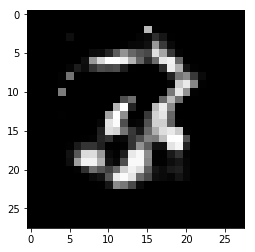

In [56]:
z_test = tch.randn(1000,d_inp_dim)
z_test = Variable(z_test.view(-1, d_inp_dim).double().cuda())
print('ztest shape: {}'.format(z_test.size()))
y = D(z_test)
print('y size: {}'.format(y.size()))
y1 = y.data.cpu().numpy().reshape(-1,28,28)
plt.imshow(y1[99,:,:], cmap='gray', interpolation='none')
plt.show()

In [34]:
#data loading and related stuff
MNISTX_train = np.load('../../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [44]:
d1 = next(MNISTd)

In [45]:
d2 = d1.reshape(-1,28,28)

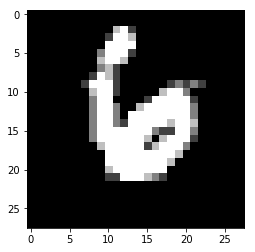

In [49]:
plt.imshow(d2[0],cmap='gray', interpolation='none')
plt.show()

In [55]:
z_mean, z_sig = E(Variable(tch.from_numpy(d1[0]).cuda()))
z_mean

Variable containing:
 0.3827
-0.0594
 0.1888
-0.0010
 0.1712
 1.4773
-0.0768
 0.6260
-0.0216
-0.1540
 0.2730
-0.8487
-1.0734
-0.6529
 1.5432
-0.6920
-0.8083
 1.2469
-0.7156
 0.0709
 0.2025
-0.3776
 0.0443
-1.5676
 0.0502
 0.1189
-2.0275
-0.3683
 1.0601
 0.6312
-0.0456
-0.4928
-0.1225
-0.0064
 0.8726
-0.2808
-0.3282
-0.0408
 0.1950
-1.1683
 0.6977
-2.9811
 0.1449
 0.0949
-1.9189
-0.1997
-0.1285
-0.3514
 1.7243
-0.1089
 1.2614
 0.2232
 0.2013
-0.2044
 0.0356
 0.0434
 0.2060
-0.2038
 0.0486
-1.1833
 1.2773
-2.8366
-0.3106
-0.5375
 0.1043
-0.2652
 0.0297
 1.5742
 0.7637
 0.3981
 0.1427
 0.9164
 0.1790
 0.1757
 0.7506
 0.1243
-0.4560
 0.0079
 0.0137
 0.4212
-0.4947
-0.9848
-0.7554
 1.3560
 0.0791
-0.9210
-0.0621
 0.1106
-0.1557
-0.0924
-0.0749
-1.1188
-0.0688
 0.4690
-0.5943
-2.7071
-0.2402
 0.0643
-0.2544
-0.2890
[torch.cuda.DoubleTensor of size 100 (GPU 0)]

In [72]:
z_test = Variable(tch.randn(1,d_inp_dim).cuda().double())*z_sig + z_mean
print(z_test.size())

torch.Size([1, 100])


torch.Size([1, 100])
y size: torch.Size([1, 784])


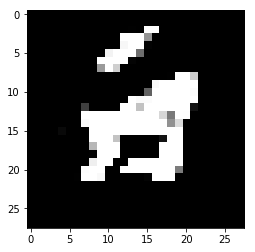

In [89]:
z_test = Variable(tch.randn(1,d_inp_dim).cuda().double())*z_sig + z_mean
print(z_test.size())
y = D(z_test)
print('y size: {}'.format(y.size()))
y1 = y.data.cpu().numpy().reshape(-1,28)
plt.imshow(y1, cmap='gray', interpolation='none')
plt.show()